<a href="https://colab.research.google.com/github/reitezuz/18NES2-2025/blob/main/week_09/time_series_jena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series prediction - Jena Climate Dataset

Inspired by: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter13_timeseries-forecasting.ipynb

# Jena Climate Dataset
The dataset contains meteorological data recorded in Jena, Germany, from 2009 to 2016. Measurement frequency: Every 10 minutes. It is suitable for time series analysis and weather prediction.
- File type: CSV (compressed in a ZIP file).

**Variables:**
- `Datetime` - Date and time of measurement.
- `Temperature (°C)` - Temperature.
- `Pressure (hPa)` - Atmospheric pressure.
- `Humidity (%)` - Relative humidity.
- `Wind speed (m/s)` - Wind speed.
- `Wind direction (°)` - Wind direction in degrees.
- `Radiation (W/m²)` - Solar radiation intensity.
- ...

**Uses:**
- Temperature or other meteorological variable prediction.
- Seasonal and trend analysis in time series data.

**Dataset Source:**

- Dataset download: [jena_climate_2009_2016.csv.zip](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)
- Kaggle: https://www.kaggle.com/datasets/mnassrib/jena-climate


## Load, observe and analyze the data

1. Download the zip file with the data
2. Extract the zip file

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

import os
# Clean up by removing the downloaded zip file
os.remove("jena_climate_2009_2016.csv.zip")


--2025-11-22 21:38:46--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.181.182, 16.15.216.75, 16.15.200.82, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.181.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  21.1MB/s    in 0.6s    

2025-11-22 21:38:47 (21.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


### Parse and observe the data

In [2]:
import pandas as pd
import numpy as np
import os

file_path = "jena_climate_2009_2016.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Extract header and number of rows using pandas
header = list(df.columns)
num_rows = len(df)

# Extract 'Temperature (°C)' column into temperature array
temperature = df['T (degC)'].values

# Create raw_data array (excluding the Date Time column)
raw_data = df.drop(columns=['Date Time']).values

print("Header:", header)
print("Number of columns:", len(header))
print("Number of rows:", num_rows)
print("Temperature array shape:", temperature.shape)
print("Raw data array shape:", raw_data.shape)

# Example: Display first few rows of the DataFrame
print(df.head())


Header: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
Number of columns: 15
Number of rows: 420451
Temperature array shape: (420451,)
Raw data array shape: (420451, 14)
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.

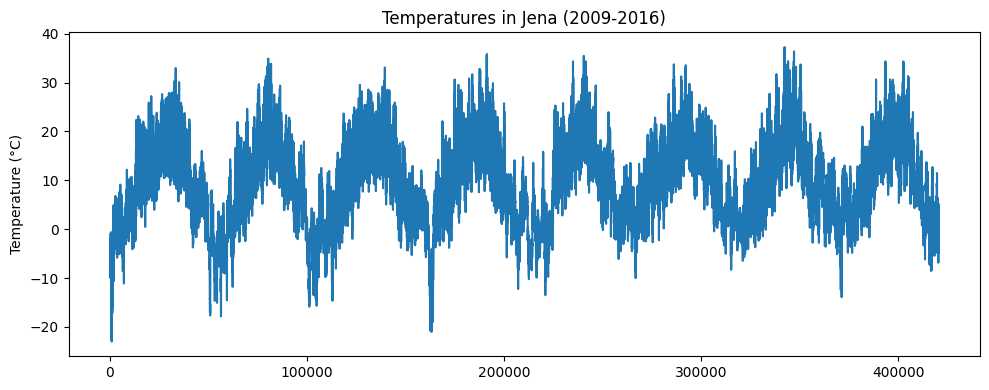

In [3]:
# Plotting the temperature timeseries
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(range(len(temperature)), temperature)
plt.title("Temperatures in Jena (2009-2016)")
#plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.show()

#

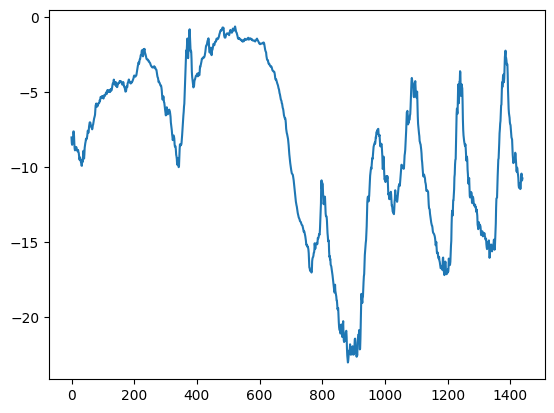

In [4]:
# Plotting the first 10 days of the temperature timeseries (24*6 = 144 points per day)
plt.plot(range(1440), temperature[:1440])

#### Observation
- We can observe periodicity over multiple timescales:
  - it is more reliable for months and less for days

### General example: creating a data loader for time series data
- create a data loader (dataset) for the time series data
- https://keras.io/api/data_loading/timeseries/

In [5]:
import numpy as np
import keras

int_sequence = np.arange(10) # 0,..,9
print(int_sequence)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    print("")
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))


[0 1 2 3 4 5 6 7 8 9]

[0, 1, 2] 3
[1, 2, 3] 4

[2, 3, 4] 5
[3, 4, 5] 6

[4, 5, 6] 7


### Our task

- We will use only data measured once per hour instead of all data (measured every 10 minutes).
- Based on the values from the previous 5 days, we will predict the temperature 24 hours ahead.
   - 24 points per day, 120 points in 5 days

### Prepare the data
- Normalize the data
- Divide the data into training (50%), validation (25%) and testing (25%) subset
  - The validation and test data should be more recent then the training data.

In [6]:
import numpy as np
import keras

# Training, validation and testing data
num_train_samples = int(0.5 * len(raw_data)) # 50 % training data
num_val_samples = int(0.25 * len(raw_data))  # 25 % validation and testing data
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

# Normalize the data:
mean_data = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean_data
std_data = raw_data[:num_train_samples].std(axis=0)
raw_data /= std_data

# Create the training, validation and testing data sets:
sampling_rate = 6        # we will use each 6th sample (1 per hour)
sequence_length = 120    # we will use data from 120 hours (5 days)
delay = sampling_rate * (sequence_length + 24 - 1) # target: value 24 hours after the end of sequence
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    #shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
print("Number of batches:", len(train_dataset))

samples shape: (256, 120, 14)
targets shape: (256,)
Number of batches: 819


In [7]:
# Data frame for results
import pandas as pd

columns = ["Model Name", "Details", "Train MAE", "Val MAE", "Test MAE", "Time (s)", "Epochs", "Train RMSE", "Val RMSE", "Test RMSE"]
results_df = pd.DataFrame(columns=columns)

## Baseline model: Naive last value predictor
- predict the temperature 24 hours ago (i.e., the last measured temperature)
- compute the error (MAE, RMSE) for the baseline model

In [8]:
def collect_naive_predictions(dataset, mean, std):
    preds_all = []
    targets_all = []

    for samples, targets in dataset:
        # last values * std + mean
        preds = samples[:, -1, 1] * std[1] + mean[1]
        targets = targets
        preds_all.append(preds)         # preds has shape (batch,)
        targets_all.append(targets)     # targets has shape (batch,)

    # concatenate batched results
    preds_all = np.concatenate(preds_all)
    targets_all = np.concatenate(targets_all)

    return preds_all, targets_all

In [9]:
# Predict on train, val, and test sets
y_train_base, y_train_true = collect_naive_predictions(train_dataset, mean_data, std_data)
y_val_base, y_val_true = collect_naive_predictions(val_dataset, mean_data, std_data)
y_test_base, y_test_true = collect_naive_predictions(test_dataset, mean_data, std_data)

# Compute metrics
def evaluate_baseline(y_true, y_pred, name=""):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse


train_mae, train_rmse = evaluate_baseline(y_train_true, y_train_base, "Train")
val_mae, val_rmse = evaluate_baseline(y_val_true, y_val_base, "Validation")
test_mae, test_rmse = evaluate_baseline(y_test_true, y_test_base, "Test")

# Add results to the dataframe:
new_entry = {
    "Model Name" : "Baseline",
    "Details" : "Previous day",
    "Train MAE" : train_mae,
    "Val MAE" : val_mae,
    "Test MAE" : test_mae,
    "Train RMSE" : train_rmse,
    "Val RMSE" : val_rmse,
    "Test RMSE" : test_rmse,
    "Epochs": 0,
    "Time (s)": -1,
}

if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
model_dir = "./models/"
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
results_df.to_csv("models/jena_results.csv", index=False)
results_df

Train MAE: 2.6916, RMSE: 3.4924
Validation MAE: 2.4417, RMSE: 3.1778
Test MAE: 2.6220, RMSE: 3.4268
Results:
  Model Name       Details  Train MAE   Val MAE  Test MAE  Train RMSE  \
0   Baseline  Previous day   2.691644  2.441733  2.622036    3.492441   

   Val RMSE  Test RMSE  Epochs  Time (s)  
0  3.177835   3.426826       0        -1  


,Model Name,Details,Train MAE,Val MAE,Test MAE,Train RMSE,Val RMSE,Test RMSE,Epochs,Time (s)
0,Baseline,Previous day,2.691644,2.441733,2.622036,3.492441,3.177835,3.426826,0,-1


## MLP model for time series (same as for regression):
- relu or tanh activation in hidden layers
- Linear activation in the output layer
- Loss: MeanSquaredError or MeanAbsoluteError
- Metrics: MAE, MSE, RMSE


### Preprocess the data

In [10]:
# flattten the data:
import tensorflow as tf

def reshape_samples(samples, targets):
    batch_size = tf.shape(samples)[0] # Use tf.shape to get the dynamic batch size
    reshaped_samples = tf.reshape(samples, (batch_size, -1))  # Flatten the samples
    return reshaped_samples, targets

train_dataset_fl = train_dataset.map(reshape_samples)
val_dataset_fl = val_dataset.map(reshape_samples)
test_dataset_fl = test_dataset.map(reshape_samples)

for samples, targets in train_dataset_fl:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
print("Number of batches:", len(train_dataset_fl))

samples shape: (256, 1680)
targets shape: (256,)
Number of batches: 819


### Define the model

In [11]:
import keras
from keras import layers
def get_MLP_model():
  # Define model architecture
  inputs = keras.Input(shape=(sequence_length * raw_data.shape[-1],))
  #x = layers.Flatten()(inputs)
  x = layers.Dense(16, activation="relu")(inputs)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs, outputs)
  return model
model = get_MLP_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        26,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,913 (105.13 KB)

 Trainable params: 26,913 (105.13 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# plot the training progress:
def plot_history(history):
    history_dict = history.history
    print(history_dict.keys())

    from matplotlib import pyplot as plt

    # Plot training & validation accuracy values
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

### Train the model

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - loss: 25.2036 - mae: 3.7528 - rmse: 4.8722 - val_loss: 10.9610 - val_mae: 2.6189 - val_rmse: 3.3107
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 58s 70ms/step - loss: 9.2538 - mae: 2.3920 - rmse: 3.0417 - val_loss: 11.1046 - val_mae: 2.6485 - val_rmse: 3.3324
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 8.1600 - mae: 2.2530 - rmse: 2.8564 - val_loss: 12.3011 - val_mae: 2.7829 - val_rmse: 3.5073
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 7.4436 - mae: 2.1540 - rmse: 2.7282 - val_loss: 11.7723 - val_mae: 2.7250 - val_rmse: 3.4311
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 7.0636 - mae: 2.0995 - rmse: 2.6577 - val_loss: 12.0265 - val_mae: 2.7457 - val_rmse: 3.4679
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 6.7924 - mae: 2.0604 - rmse: 2.6062 - val_loss: 12.2843 - val_mae: 2.7759 - val_rmse: 3.5049
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 6.5599 

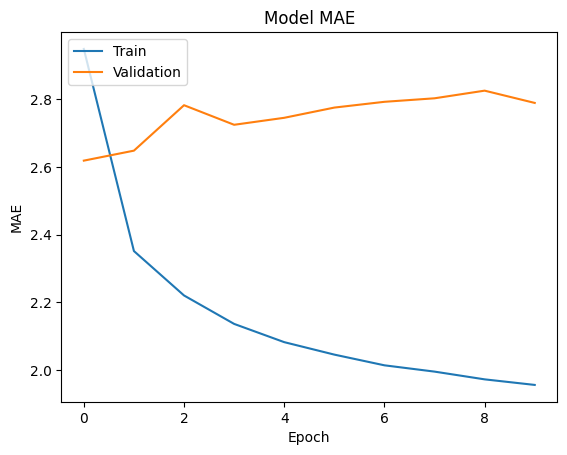

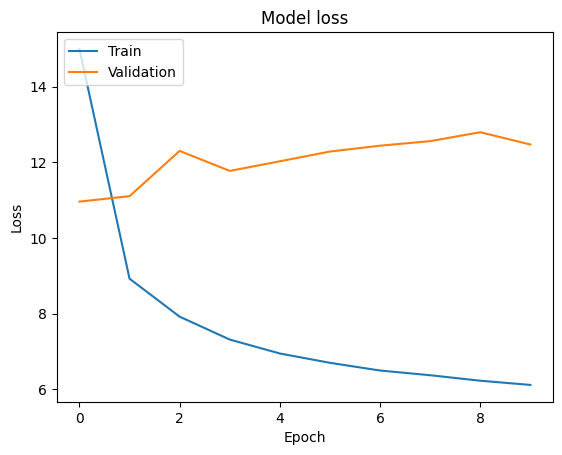

819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 56ms/step - loss: 9.4748 - mae: 2.4148 - rmse: 3.0781
408/408 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 10.9691 - mae: 2.6182 - rmse: 3.3119
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 12.4600 - mae: 2.7414 - rmse: 3.5224
Train      MAE: 2.41, RMSE: 3.08
Validation MAE: 2.62, RMSE: 3.31
Test       MAE: 2.73, RMSE: 3.48
Results:
       Model Name       Details  Train MAE   Val MAE  Test MAE  Train RMSE  \
0        Baseline  Previous day   2.691644  2.441733  2.622036    3.492441   
1  jena_mlp.keras                 2.414943  2.618946  2.726148    3.077383   

   Val RMSE  Test RMSE  Epochs    Time (s)  
0  3.177835   3.426826       0   -1.000000  
1  3.310736   3.480005      10  565.406122  
Results:


,Model Name,Details,Train MAE,Val MAE,Test MAE,Train RMSE,Val RMSE,Test RMSE,Epochs,Time (s)
0,Baseline,Previous day,2.691644,2.441733,2.622036,3.492441,3.177835,3.426826,0,-1.000000
1,jena_mlp.keras,,2.414943,2.618946,2.726148,3.077383,3.310736,3.480005,10,565.406122


In [13]:
# Set some of the hyperparameters:
do_early_stopping = False
do_checkpoint = True
do_tensorboard = True
max_epochs = 10
model_name = "jena_mlp.keras"
details = "" # your comment

###############################################
# Define the model architecture:
model = get_MLP_model()

# Configure the model:
model.compile(optimizer= keras.optimizers.Adam(), # SGD, Adam, RMSProp
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError(name="mae"), keras.metrics.RootMeanSquaredError(name="rmse")])

# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
if do_checkpoint:
    from keras.callbacks import ModelCheckpoint
    checkpoint =     keras.callbacks.ModelCheckpoint(
        filepath="./models/" + model_name,
        save_best_only=True,
        monitor="val_loss")
    callbacks.append(checkpoint)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_jena/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_dataset_fl,
                    epochs=max_epochs,
                    validation_data=val_dataset_fl,
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

if do_checkpoint:
    # Load the best model
    model = keras.models.load_model("./models/" + model_name)


# Evaluate the model on the training, validation and test sets
train_loss, train_mae, train_rmse = model.evaluate(train_dataset_fl)
val_loss, val_mae, val_rmse = model.evaluate(val_dataset_fl)
test_loss, test_mae, test_rmse = model.evaluate(test_dataset_fl)

print(f"Train      MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}")
print(f"Validation MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")
print(f"Test       MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name,
    "Details" : details,
    "Train MAE" : train_mae,
    "Val MAE" : val_mae,
    "Test MAE" : test_mae,
    "Train RMSE" : train_rmse,
    "Val RMSE" : val_rmse,
    "Test RMSE" : test_rmse,
    "Epochs": max_epochs,
    "Time (s)": time_fit,
}
if 'results_df' not in locals() or results_df is None or results_df.empty:
    results_df = pd.DataFrame([new_entry])
else:
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# View and and save the dataframe:
results_df.to_csv("models/jena_results.csv", index=False)
print("Results:")
results_df

In [14]:
import matplotlib.pyplot as plt

def plot_predictions(dataset, model, num_samples=24, start_index=0):
    """Plots predicted vs. real outputs starting from a specific index."""
    preds_list = []
    targets_list = []

    samples_seen = 0
    total_seen = 0

    for samples, targets in dataset:
        batch_size = samples.shape[0]
        if total_seen + batch_size <= start_index:
            total_seen += batch_size
            continue

        batch_start_index = max(0, start_index - total_seen)

        preds = model.predict(samples, verbose = 0)
        preds_list.extend(preds.reshape(-1)[batch_start_index:])
        targets_list.extend(targets[batch_start_index:])

        samples_seen += batch_size - batch_start_index
        total_seen += batch_size

        if samples_seen >= num_samples:
            break

    # Zkrácení na požadovaný počet vzorků
    preds_list = preds_list[:num_samples]
    targets_list = targets_list[:num_samples]

    plt.figure(figsize=(10, 3))
    plt.plot(targets_list, label='Real Values')
    plt.plot(preds_list, label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Temperature (°C)')
    plt.title('Predicted vs. Real Temperature')
    plt.legend()
    plt.show()


### Observe the results

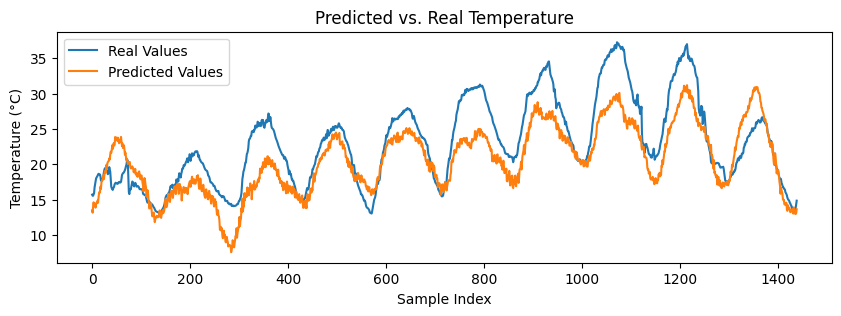

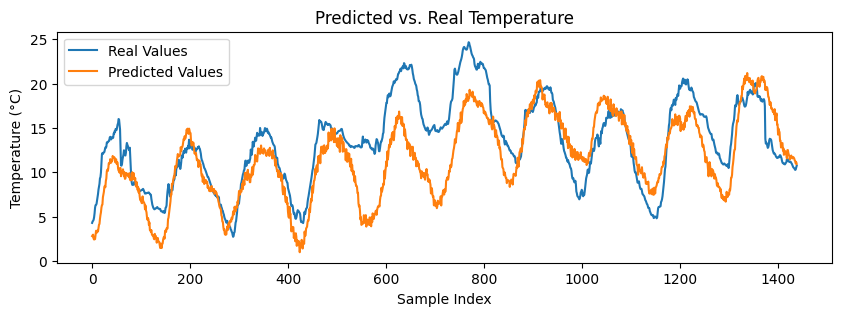

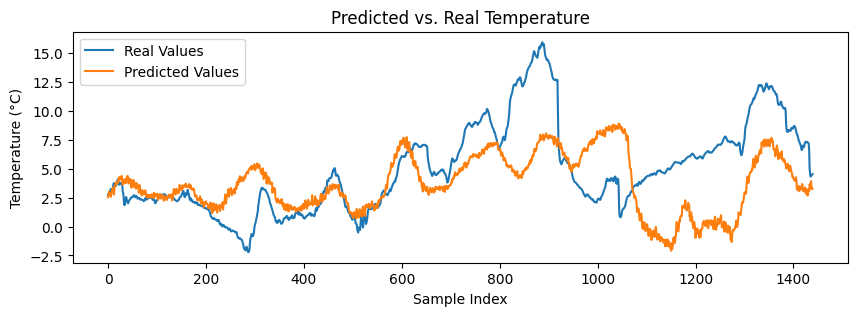

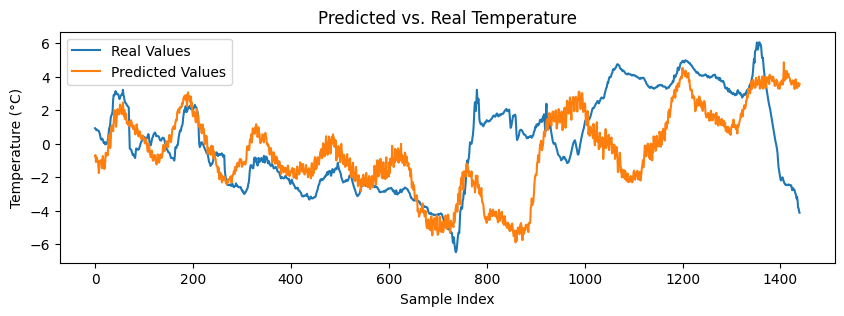

In [15]:
model = keras.models.load_model("models/jena_mlp.keras")
for start_index in [ 24*6*6*29,  24*6*4*29, 24, 24*6*1*29,]:
    plot_predictions(test_dataset_fl, model, 24*6*10, start_index)

## 1D CNN Model

### Define the model

In [17]:
import keras
from keras import layers

# Define the model architecture:
def get_CNN_model():
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

    x = layers.Conv1D(filters=8, kernel_size=24, activation="relu")(inputs)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(8, 12, activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(8, 6, activation="relu")(x)

    # Flatten
    x = layers.GlobalAveragePooling1D()(x)

    outputs = layers.Dense(1)(x) # linear output

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
model = get_CNN_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 97, 8)          │         2,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 37, 8)          │           776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 18, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 13, 8)          │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,873 (15.13 KB)

 Trainable params: 3,873 (15.13 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - loss: 39.4645 - mae: 4.6902 - rmse: 6.0890 - val_loss: 15.1327 - val_mae: 3.0739 - val_rmse: 3.8901
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step - loss: 14.5168 - mae: 3.0284 - rmse: 3.8100 - val_loss: 14.6347 - val_mae: 3.0251 - val_rmse: 3.8255
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 77s 63ms/step - loss: 13.0837 - mae: 2.8688 - rmse: 3.6171 - val_loss: 14.0200 - val_mae: 2.9543 - val_rmse: 3.7443
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 78ms/step - loss: 12.2414 - mae: 2.7692 - rmse: 3.4987 - val_loss: 13.3440 - val_mae: 2.8885 - val_rmse: 3.6529
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step - loss: 11.5709 - mae: 2.6867 - rmse: 3.4015 - val_loss: 13.6210 - val_mae: 2.9170 - val_rmse: 3.6907
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 11.1491 - mae: 2.6373 - rmse: 3.3390 - val_loss: 13.3472 - val_mae: 2.8912 - val_rmse: 3.6534
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 10

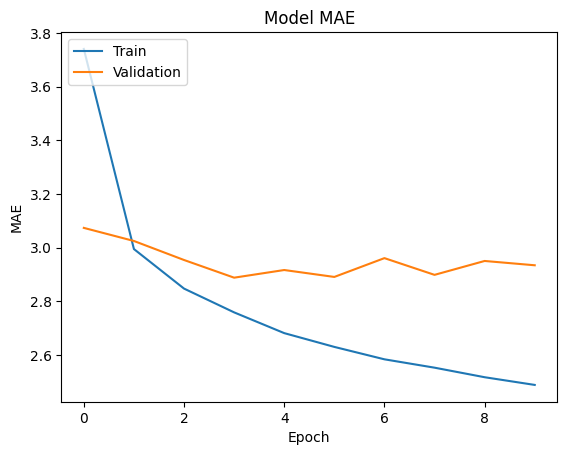

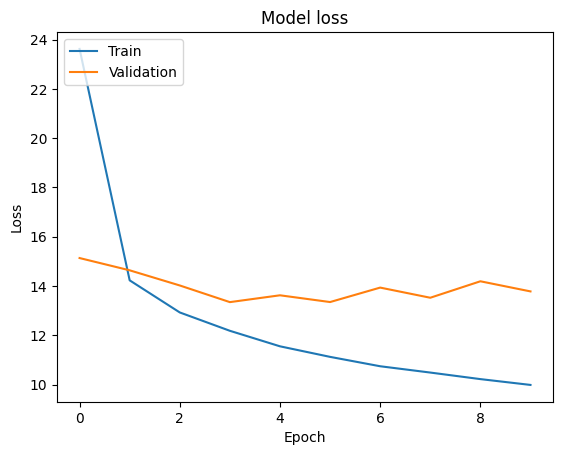

819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - loss: 11.6105 - mae: 2.6925 - rmse: 3.4074
408/408 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 13.4208 - mae: 2.9009 - rmse: 3.6634
405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - loss: 15.2000 - mae: 3.1070 - rmse: 3.8933
Train      MAE: 2.70, RMSE: 3.42
Validation MAE: 2.89, RMSE: 3.65
Test       MAE: 3.09, RMSE: 3.88
Results:
       Model Name       Details  Train MAE   Val MAE  Test MAE  Train RMSE  \
0        Baseline  Previous day   2.691644  2.441733  2.622036    3.492441   
1  jena_mlp.keras                 2.414943  2.618946  2.726148    3.077383   
2  jena_cnn.keras                 2.698550  2.888454  3.086106    3.418401   

   Val RMSE  Test RMSE  Epochs    Time (s)  
0  3.177835   3.426826       0   -1.000000  
1  3.310736   3.480005      10  565.406122  
2  3.652940   3.879384      10  586.353555  
Results:


,Model Name,Details,Train MAE,Val MAE,Test MAE,Train RMSE,Val RMSE,Test RMSE,Epochs,Time (s)
0,Baseline,Previous day,2.691644,2.441733,2.622036,3.492441,3.177835,3.426826,0,-1.000000
1,jena_mlp.keras,,2.414943,2.618946,2.726148,3.077383,3.310736,3.480005,10,565.406122
2,jena_cnn.keras,,2.698550,2.888454,3.086106,3.418401,3.652940,3.879384,10,586.353555


In [18]:
# Set some of the hyperparameters:
do_early_stopping = False
do_checkpoint = True
do_tensorboard = True
max_epochs = 10
model_name = "jena_cnn.keras"
details = "" # your comment

###############################################
# Define the model architecture:
model = get_CNN_model()

# Configure the model:
model.compile(optimizer= keras.optimizers.Adam(), # SGD, Adam, RMSProp
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError(name="mae"), keras.metrics.RootMeanSquaredError(name="rmse")])

# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
if do_checkpoint:
    from keras.callbacks import ModelCheckpoint
    checkpoint =     keras.callbacks.ModelCheckpoint(
        filepath="./models/" + model_name,
        save_best_only=True,
        monitor="val_loss")
    callbacks.append(checkpoint)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_jena/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    validation_data=val_dataset,
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

if do_checkpoint:
    # Load the best model
    model = keras.models.load_model("./models/" + model_name)


# Evaluate the model on the training, validation and test sets
train_loss, train_mae, train_rmse = model.evaluate(train_dataset)
val_loss, val_mae, val_rmse = model.evaluate(val_dataset)
test_loss, test_mae, test_rmse = model.evaluate(test_dataset)

print(f"Train      MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}")
print(f"Validation MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")
print(f"Test       MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name,
    "Details" : details,
    "Train MAE" : train_mae,
    "Val MAE" : val_mae,
    "Test MAE" : test_mae,
    "Train RMSE" : train_rmse,
    "Val RMSE" : val_rmse,
    "Test RMSE" : test_rmse,
    "Epochs": max_epochs,
    "Time (s)": time_fit,
}
if 'results_df' not in locals() or results_df is None or results_df.empty:
    results_df = pd.DataFrame([new_entry])
else:
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# View and and save the dataframe:
results_df.to_csv("models/jena_results.csv", index=False)
print("Results:")
results_df

### Observe the results

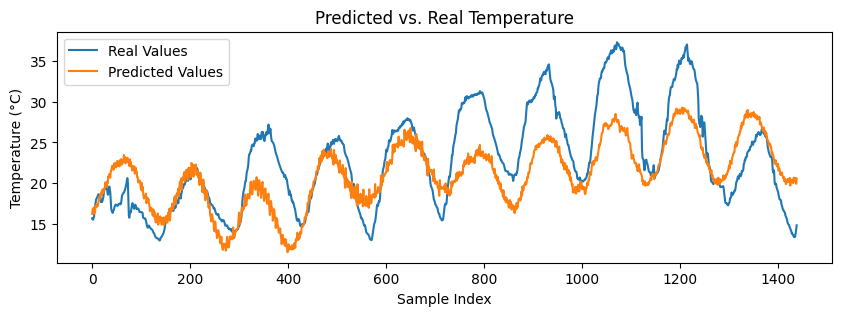

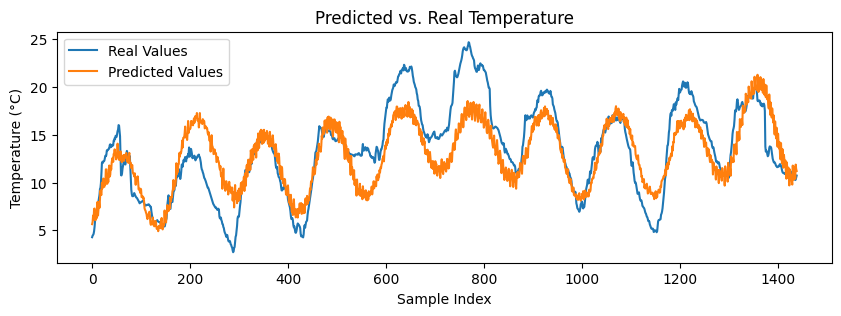

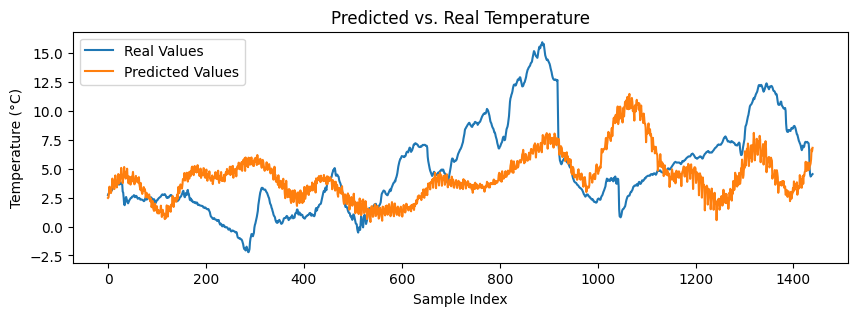

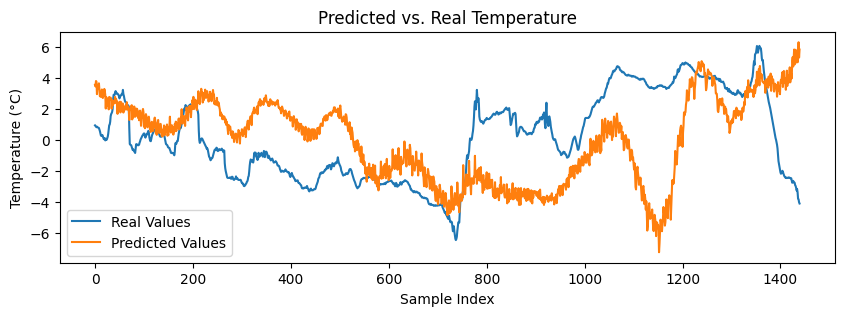

In [21]:
model = keras.models.load_model("models/jena_cnn.keras")
for start_index in [ 24*6*6*29,  24*6*4*29, 24, 24*6*1*29,]:
    plot_predictions(test_dataset, model, 24*6*10, start_index)

## A simple LSTM model





### Define the model

In [22]:
import keras
from keras import layers

def get_LSTM_model():
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

    x = layers.LSTM(16)(inputs)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model
model = get_LSTM_model()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 84ms/step - loss: 86.9875 - mae: 7.2526 - rmse: 9.2148 - val_loss: 20.7142 - val_mae: 3.3787 - val_rmse: 4.5513
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 18.6518 - mae: 3.2483 - rmse: 4.3148 - val_loss: 11.8980 - val_mae: 2.6185 - val_rmse: 3.4493
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 12.2669 - mae: 2.7010 - rmse: 3.5021 - val_loss: 10.3492 - val_mae: 2.4751 - val_rmse: 3.2170
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 10.6411 - mae: 2.5390 - rmse: 3.2621 - val_loss: 9.8062 - val_mae: 2.4196 - val_rmse: 3.1315
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - loss: 10.0857 - mae: 2.4706 - rmse: 3.1758 - val_loss: 9.4272 - val_mae: 2.3757 - val_rmse: 3.0704
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 9.5996 - mae: 2.4075 - rmse: 3.0983 - val_loss: 9.4584 - val_mae: 2.3804 - val_rmse: 3.0755
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 9.1756

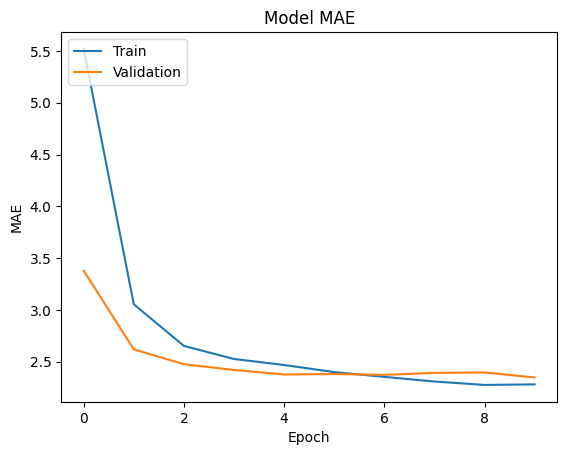

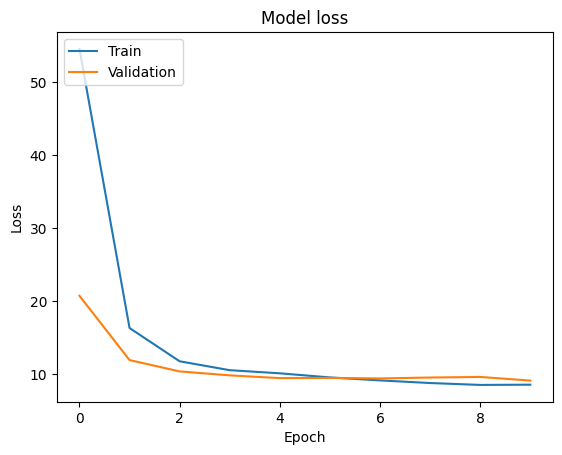

819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 8.6737 - mae: 2.3036 - rmse: 2.9451
408/408 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 9.0767 - mae: 2.3481 - rmse: 3.0127
405/405 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 11.6384 - mae: 2.6616 - rmse: 3.4069
Train      MAE: 2.30, RMSE: 2.94
Validation MAE: 2.35, RMSE: 3.02
Test       MAE: 2.54, RMSE: 3.25
Results:
        Model Name       Details  Train MAE   Val MAE  Test MAE  Train RMSE  \
0         Baseline  Previous day   2.691644  2.441733  2.622036    3.492441   
1   jena_mlp.keras                 2.414943  2.618946  2.726148    3.077383   
2   jena_cnn.keras                 2.698550  2.888454  3.086106    3.418401   
3  jena_lstm.keras                 2.303099  2.347220  2.535858    2.943547   

   Val RMSE  Test RMSE  Epochs    Time (s)  
0  3.177835   3.426826       0   -1.000000  
1  3.310736   3.480005      10  565.406122  
2  3.652940   3.879384      10  586.353555  
3  3.015329   3.245805      10  512.362530  
Results:


,Model Name,Details,Train MAE,Val MAE,Test MAE,Train RMSE,Val RMSE,Test RMSE,Epochs,Time (s)
0,Baseline,Previous day,2.691644,2.441733,2.622036,3.492441,3.177835,3.426826,0,-1.000000
1,jena_mlp.keras,,2.414943,2.618946,2.726148,3.077383,3.310736,3.480005,10,565.406122
2,jena_cnn.keras,,2.698550,2.888454,3.086106,3.418401,3.652940,3.879384,10,586.353555
3,jena_lstm.keras,,2.303099,2.347220,2.535858,2.943547,3.015329,3.245805,10,512.362530


In [23]:
# Set some of the hyperparameters:
do_early_stopping = False
do_checkpoint = True
do_tensorboard = True
max_epochs = 10
model_name = "jena_lstm.keras"
details = "" # your comment

###############################################
# Define the model architecture:
model = get_LSTM_model()

# Configure the model:
model.compile(optimizer= keras.optimizers.Adam(), # SGD, Adam, RMSProp
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError(name="mae"), keras.metrics.RootMeanSquaredError(name="rmse")])

# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
if do_checkpoint:
    from keras.callbacks import ModelCheckpoint
    checkpoint =     keras.callbacks.ModelCheckpoint(
        filepath="./models/" + model_name,
        save_best_only=True,
        monitor="val_loss")
    callbacks.append(checkpoint)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_jena/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    validation_data=val_dataset,
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

if do_checkpoint:
    # Load the best model
    model = keras.models.load_model("./models/" + model_name)


# Evaluate the model on the training, validation and test sets
train_loss, train_mae, train_rmse = model.evaluate(train_dataset)
val_loss, val_mae, val_rmse = model.evaluate(val_dataset)
test_loss, test_mae, test_rmse = model.evaluate(test_dataset)

print(f"Train      MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}")
print(f"Validation MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")
print(f"Test       MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name,
    "Details" : details,
    "Train MAE" : train_mae,
    "Val MAE" : val_mae,
    "Test MAE" : test_mae,
    "Train RMSE" : train_rmse,
    "Val RMSE" : val_rmse,
    "Test RMSE" : test_rmse,
    "Epochs": max_epochs,
    "Time (s)": time_fit,
}
if 'results_df' not in locals() or results_df is None or results_df.empty:
    results_df = pd.DataFrame([new_entry])
else:
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# View and and save the dataframe:
results_df.to_csv("models/jena_results.csv", index=False)
print("Results:")
results_df

### Observe the results

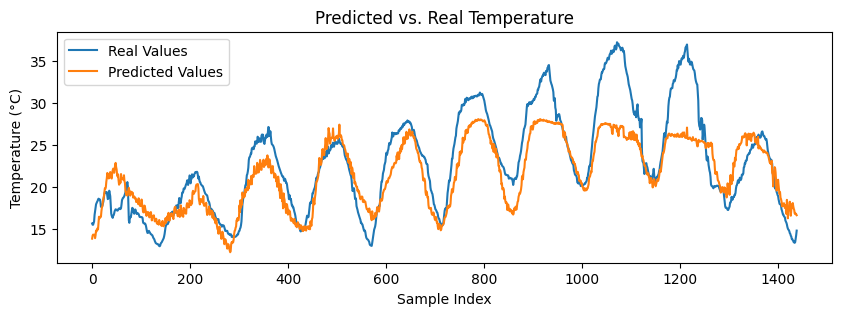

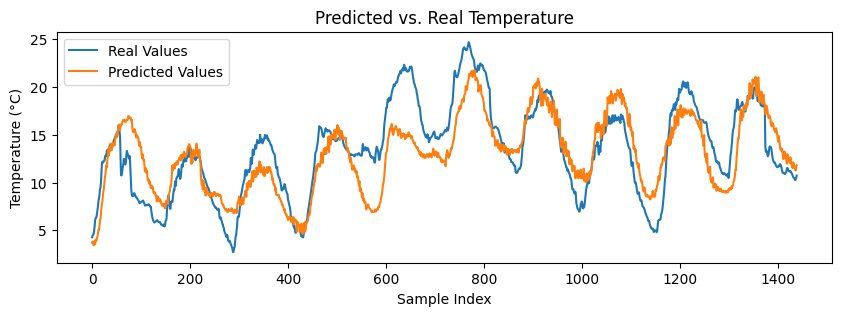

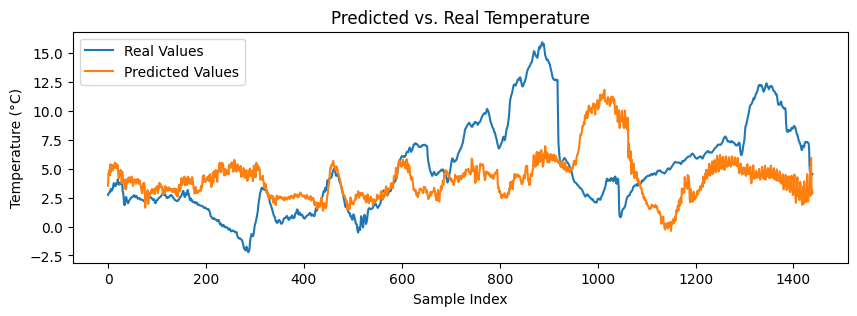

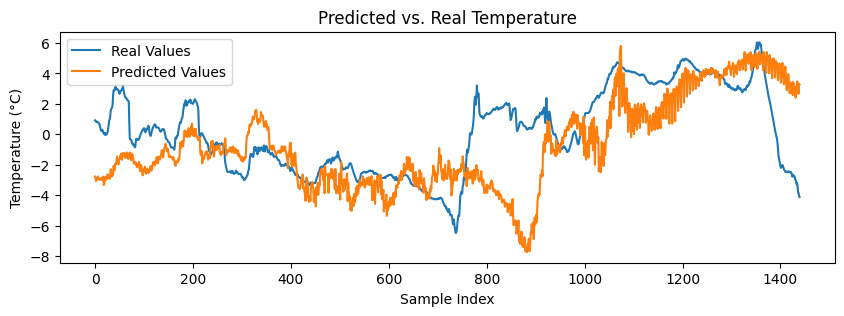

In [24]:
model = keras.models.load_model("models/jena_lstm.keras")
for start_index in [ 24*6*6*29,  24*6*4*29, 24, 24*6*1*29,]:
    plot_predictions(test_dataset, model, 24*6*10, start_index)

## GRU

### Define the model

In [25]:
import keras
from keras import layers

def get_GRU_model():
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

    x = layers.GRU(16)(inputs) # change

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model
model = get_GRU_model()
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,553 (6.07 KB)

 Trainable params: 1,553 (6.07 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 79.4494 - mae: 6.8425 - rmse: 8.7619 - val_loss: 17.8027 - val_mae: 3.1024 - val_rmse: 4.2193
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 15.1116 - mae: 2.9201 - rmse: 3.8854 - val_loss: 11.3894 - val_mae: 2.5507 - val_rmse: 3.3748
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - loss: 11.1290 - mae: 2.5723 - rmse: 3.3359 - val_loss: 10.0890 - val_mae: 2.4372 - val_rmse: 3.1763
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - loss: 10.0485 - mae: 2.4644 - rmse: 3.1699 - val_loss: 9.8341 - val_mae: 2.4165 - val_rmse: 3.1359
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 9.4781 - mae: 2.3974 - rmse: 3.0786 - val_loss: 9.5134 - val_mae: 2.3839 - val_rmse: 3.0844
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 9.0552 - mae: 2.3457 - rmse: 3.0092 - val_loss: 9.5545 - val_mae: 2.3894 - val_rmse: 3.0910
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 8.7934 

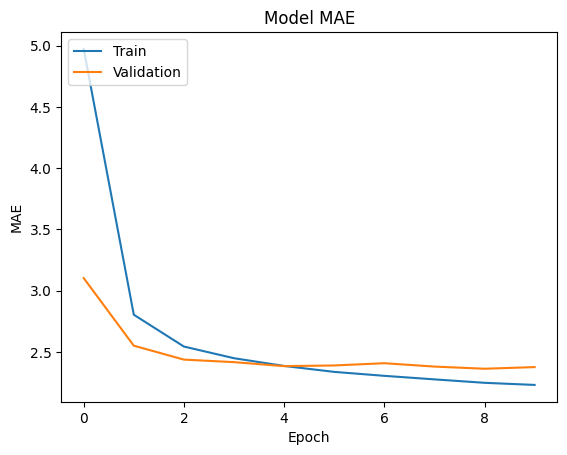

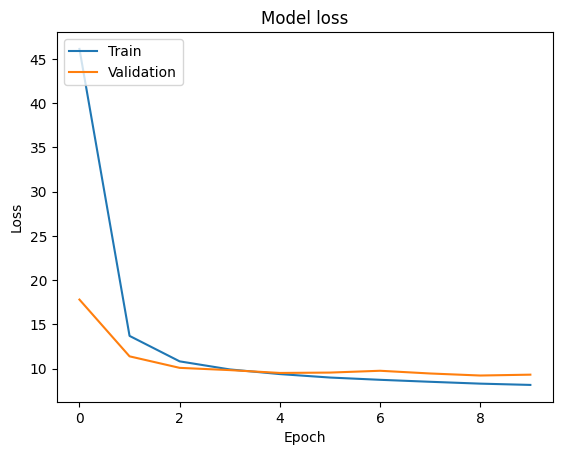

819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 8.1877 - mae: 2.2337 - rmse: 2.8614
408/408 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - loss: 9.1910 - mae: 2.3577 - rmse: 3.0316
405/405 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - loss: 10.6829 - mae: 2.5658 - rmse: 3.2629
Train      MAE: 2.23, RMSE: 2.86
Validation MAE: 2.36, RMSE: 3.04
Test       MAE: 2.50, RMSE: 3.16
Results:
        Model Name       Details  Train MAE   Val MAE  Test MAE  Train RMSE  \
0         Baseline  Previous day   2.691644  2.441733  2.622036    3.492441   
1   jena_mlp.keras                 2.414943  2.618946  2.726148    3.077383   
2   jena_cnn.keras                 2.698550  2.888454  3.086106    3.418401   
3  jena_lstm.keras                 2.303099  2.347220  2.535858    2.943547   
4   jena_gru.keras                 2.230843  2.362709  2.495239    2.857363   

   Val RMSE  Test RMSE  Epochs    Time (s)  
0  3.177835   3.426826       0   -1.000000  
1  3.310736   3.480005      10  565.406122  
2  3.652940   3.8793

,Model Name,Details,Train MAE,Val MAE,Test MAE,Train RMSE,Val RMSE,Test RMSE,Epochs,Time (s)
0,Baseline,Previous day,2.691644,2.441733,2.622036,3.492441,3.177835,3.426826,0,-1.000000
1,jena_mlp.keras,,2.414943,2.618946,2.726148,3.077383,3.310736,3.480005,10,565.406122
2,jena_cnn.keras,,2.698550,2.888454,3.086106,3.418401,3.652940,3.879384,10,586.353555
3,jena_lstm.keras,,2.303099,2.347220,2.535858,2.943547,3.015329,3.245805,10,512.362530
4,jena_gru.keras,,2.230843,2.362709,2.495239,2.857363,3.036922,3.162728,10,494.133486


In [26]:
# Set some of the hyperparameters:
do_early_stopping = False
do_checkpoint = True
do_tensorboard = True
max_epochs = 10
model_name = "jena_gru.keras"
details = "" # your comment

###############################################
# Define the model architecture:
model = get_GRU_model()

# Configure the model:
model.compile(optimizer= keras.optimizers.Adam(), # SGD, Adam, RMSProp
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError(name="mae"), keras.metrics.RootMeanSquaredError(name="rmse")])

# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
if do_checkpoint:
    from keras.callbacks import ModelCheckpoint
    checkpoint =     keras.callbacks.ModelCheckpoint(
        filepath="./models/" + model_name,
        save_best_only=True,
        monitor="val_loss")
    callbacks.append(checkpoint)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_jena/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    validation_data=val_dataset,
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

if do_checkpoint:
    # Load the best model
    model = keras.models.load_model("./models/" + model_name)


# Evaluate the model on the training, validation and test sets
train_loss, train_mae, train_rmse = model.evaluate(train_dataset)
val_loss, val_mae, val_rmse = model.evaluate(val_dataset)
test_loss, test_mae, test_rmse = model.evaluate(test_dataset)

print(f"Train      MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}")
print(f"Validation MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")
print(f"Test       MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name,
    "Details" : details,
    "Train MAE" : train_mae,
    "Val MAE" : val_mae,
    "Test MAE" : test_mae,
    "Train RMSE" : train_rmse,
    "Val RMSE" : val_rmse,
    "Test RMSE" : test_rmse,
    "Epochs": max_epochs,
    "Time (s)": time_fit,
}
if 'results_df' not in locals() or results_df is None or results_df.empty:
    results_df = pd.DataFrame([new_entry])
else:
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# View and and save the dataframe:
results_df.to_csv("models/jena_results.csv", index=False)
print("Results:")
results_df

### Observe the results

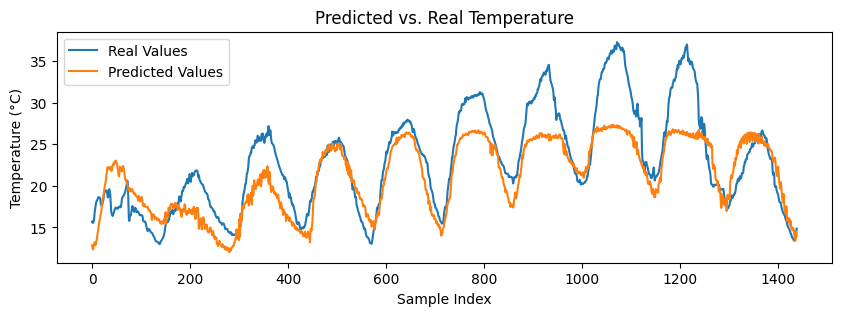

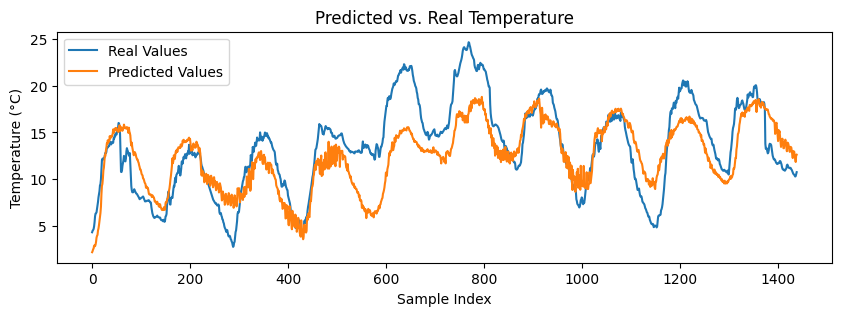

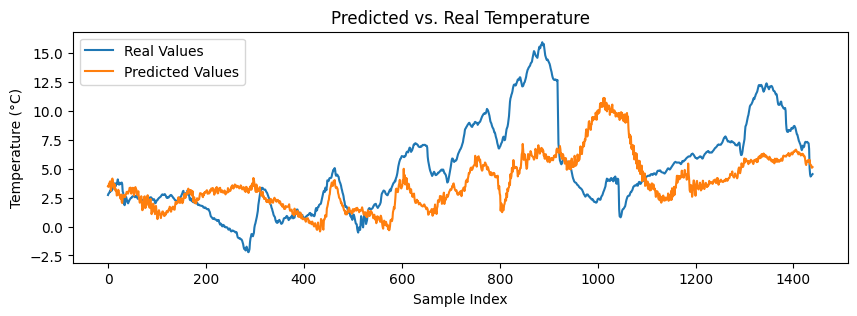

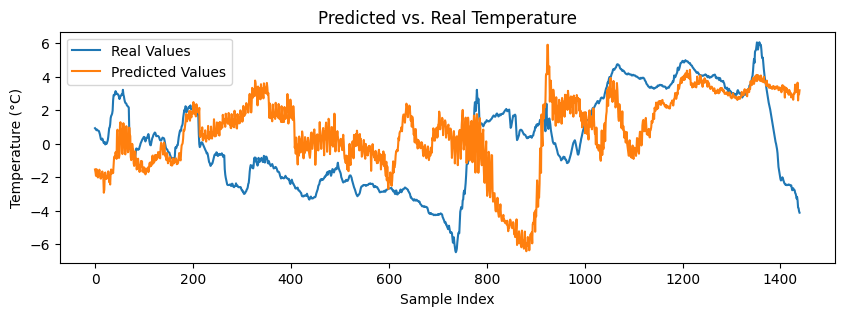

In [27]:
model = keras.models.load_model("models/jena_gru.keras")
for start_index in [ 24*6*6*29,  24*6*4*29, 24, 24*6*1*29,]:
    plot_predictions(test_dataset, model, 24*6*10, start_index)

## LSTM with dropout and gradient clipping

### Define the model

In [28]:
import keras
from keras import layers

def get_regularized_LSTM_model():
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = layers.LSTM(32, recurrent_dropout=0.25)(inputs) # change 16 -> 32.
    x = layers.Dropout(0.5)(x)                          # dropout
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model

model = get_regularized_LSTM_model()
model.summary()

# optimizer= keras.optimizers.Adam(clipnorm=1.0)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,049 (23.63 KB)

 Trainable params: 6,049 (23.63 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
# Set some of the hyperparameters:
do_early_stopping = False
do_checkpoint = True
do_tensorboard = True
max_epochs = 30      # change !!!!!!!!!
model_name = "jena_reg_lstm.keras"
details = "" # your comment

###############################################
# Define the model architecture:
model = get_regularized_LSTM_model()

# Configure the model:
model.compile(optimizer= keras.optimizers.Adam(clipnorm=1.0),  # change !!!!!!
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError(name="mae"), keras.metrics.RootMeanSquaredError(name="rmse")])

# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
if do_checkpoint:
    from keras.callbacks import ModelCheckpoint
    checkpoint =     keras.callbacks.ModelCheckpoint(
        filepath="./models/" + model_name,
        save_best_only=True,
        monitor="val_loss")
    callbacks.append(checkpoint)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_jena/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    validation_data=val_dataset,
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

if do_checkpoint:
    # Load the best model
    model = keras.models.load_model("./models/" + model_name)


# Evaluate the model on the training, validation and test sets
train_loss, train_mae, train_rmse = model.evaluate(train_dataset)
val_loss, val_mae, val_rmse = model.evaluate(val_dataset)
test_loss, test_mae, test_rmse = model.evaluate(test_dataset)

print(f"Train      MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}")
print(f"Validation MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")
print(f"Test       MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name,
    "Details" : details,
    "Train MAE" : train_mae,
    "Val MAE" : val_mae,
    "Test MAE" : test_mae,
    "Train RMSE" : train_rmse,
    "Val RMSE" : val_rmse,
    "Test RMSE" : test_rmse,
    "Epochs": max_epochs,
    "Time (s)": time_fit,
}
if 'results_df' not in locals() or results_df is None or results_df.empty:
    results_df = pd.DataFrame([new_entry])
else:
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# View and and save the dataframe:
results_df.to_csv("models/jena_results.csv", index=False)
print("Results:")
results_df

Epoch 1/30
201/819 ━━━━━━━━━━━━━━━━━━━━ 3:47 368ms/step - loss: 103.4557 - mae: 8.1184 - rmse: 10.0952

### Observe the results

In [ ]:
model = keras.models.load_model("models/jena_reg_lstm.keras")
for start_index in [ 24*6*6*29,  24*6*4*29, 24, 24*6*1*29,]:
    plot_predictions(test_dataset, model, 24*6*10, start_index)

In [ ]:
print(results_df)

In [ ]:
#results_df = results_df.drop(6, axis=0).reset_index(drop=True)

## GRU with more layers

### Define the model

In [ ]:
import keras
from keras import layers

def get_layered_GRU_model():
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

    x = layers.GRU(16, return_sequences=True)(inputs)

    x = layers.GRU(16)(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model

model = get_layered_GRU_model()
model.summary()

### Train the model

In [ ]:
# Set some of the hyperparameters:
do_early_stopping = False
do_checkpoint = True
do_tensorboard = True
max_epochs = 20      # change !!!!!!!!!
model_name = "jena_layered_gru.keras"
details = "" # your comment

###############################################
# Define the model architecture:
model = get_layered_GRU_model()

# Configure the model:
model.compile(optimizer= keras.optimizers.Adam(clipnorm=1.0),  # change !!!!!!
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError(name="mae"), keras.metrics.RootMeanSquaredError(name="rmse")])

# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
if do_checkpoint:
    from keras.callbacks import ModelCheckpoint
    checkpoint =     keras.callbacks.ModelCheckpoint(
        filepath="./models/" + model_name,
        save_best_only=True,
        monitor="val_loss")
    callbacks.append(checkpoint)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_jena/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    validation_data=val_dataset,
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

if do_checkpoint:
    # Load the best model
    model = keras.models.load_model("./models/" + model_name)


# Evaluate the model on the training, validation and test sets
train_loss, train_mae, train_rmse = model.evaluate(train_dataset)
val_loss, val_mae, val_rmse = model.evaluate(val_dataset)
test_loss, test_mae, test_rmse = model.evaluate(test_dataset)

print(f"Train      MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}")
print(f"Validation MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")
print(f"Test       MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name,
    "Details" : details,
    "Train MAE" : train_mae,
    "Val MAE" : val_mae,
    "Test MAE" : test_mae,
    "Train RMSE" : train_rmse,
    "Val RMSE" : val_rmse,
    "Test RMSE" : test_rmse,
    "Epochs": max_epochs,
    "Time (s)": time_fit,
}
if 'results_df' not in locals() or results_df is None or results_df.empty:
    results_df = pd.DataFrame([new_entry])
else:
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# View and and save the dataframe:
results_df.to_csv("models/jena_results.csv", index=False)
print("Results:")
results_df

### Observe the results

In [ ]:
model = keras.models.load_model("models/jena_layered_gru.keras")
for start_index in [ 24*6*6*29,  24*6*4*29, 24, 24*6*1*29,]:
    plot_predictions(test_dataset, model, 24*6*10, start_index)

## Bidirectional RNN

### Define the model

In [ ]:
import keras
from keras import layers

def get_bi_LSTM_model():
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = layers.Bidirectional(layers.LSTM(16))(inputs)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model

model = get_bi_LSTM_model()
model.summary()

# optimizer= keras.optimizers.Adam(clipnorm=1.0)

### Train the model

In [ ]:
# Set some of the hyperparameters:
do_early_stopping = False
do_checkpoint = True
do_tensorboard = True
max_epochs = 10      # change !!!!!!!!!
model_name = "jena_bi_lstm.keras"
details = "" # your comment

###############################################
# Define the model architecture:
model = get_layered_GRU_model()

# Configure the model:
model.compile(optimizer= keras.optimizers.Adam(clipnorm=1.0),  # change !!!!!!
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError(name="mae"), keras.metrics.RootMeanSquaredError(name="rmse")])

# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
if do_checkpoint:
    from keras.callbacks import ModelCheckpoint
    checkpoint =     keras.callbacks.ModelCheckpoint(
        filepath="./models/" + model_name,
        save_best_only=True,
        monitor="val_loss")
    callbacks.append(checkpoint)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_jena/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    validation_data=val_dataset,
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

if do_checkpoint:
    # Load the best model
    model = keras.models.load_model("./models/" + model_name)


# Evaluate the model on the training, validation and test sets
train_loss, train_mae, train_rmse = model.evaluate(train_dataset)
val_loss, val_mae, val_rmse = model.evaluate(val_dataset)
test_loss, test_mae, test_rmse = model.evaluate(test_dataset)

print(f"Train      MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}")
print(f"Validation MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")
print(f"Test       MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_name,
    "Details" : details,
    "Train MAE" : train_mae,
    "Val MAE" : val_mae,
    "Test MAE" : test_mae,
    "Train RMSE" : train_rmse,
    "Val RMSE" : val_rmse,
    "Test RMSE" : test_rmse,
    "Epochs": max_epochs,
    "Time (s)": time_fit,
}
if 'results_df' not in locals() or results_df is None or results_df.empty:
    results_df = pd.DataFrame([new_entry])
else:
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# View and and save the dataframe:
results_df.to_csv("models/jena_results.csv", index=False)
print("Results:")
results_df

### Observe the results

In [ ]:
model = keras.models.load_model("models/jena_bi_lstm.keras")
for start_index in [ 24*6*6*29,  24*6*4*29, 24, 24*6*1*29,]:
    plot_predictions(test_dataset, model, 24*6*10, start_index)

In [ ]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs_jena  --reload_interval=1